### Principal Component Analysis

#### Some basic data exploration 

In [5]:
from datetime import date

import pandas_datareader.data as web
import pandas as pd
import matplotlib.ticker as mtick

In [6]:
report_start = date.fromisoformat('2020-01-01')
report_end = date.today()

In [7]:
data = web.get_data_fred(['DGS5', 'DGS10', 'T5YIE', 'T10YIE', 'T10Y2Y', 'T10Y3M'], report_start, report_end) / 100.
data.dropna(inplace=True)

columns_with_semiannual_comp = [0, 1, 3, 4]

# Converting all CMT Yields to APY (i.e. all but breakeven inflation rates)
data.iloc[:, columns_with_semiannual_comp] = (data.iloc[:, columns_with_semiannual_comp]/2 + 1)**2 - 1

In [8]:
data['10y Tr. Yield - 5y Tr. Yield'] = data.DGS10 - data.DGS5
data['10y Breakeven Infl. Rate - 5y Breakeven Infl. Rate'] = data.T10YIE - data.T5YIE
data.rename(columns={'T10Y2Y': '10y Tr. Yield - 2y Tr. Yield',
                     'T10Y3M': '10y Tr. Yield - 3m Tr. Yield'}, inplace=True)

In [9]:
# Get rid of columns no longer required
data.drop(columns=data.columns[0:4], inplace=True)

# Rearrange columns
data = data.iloc[:, [2, 3, 0, 1]]

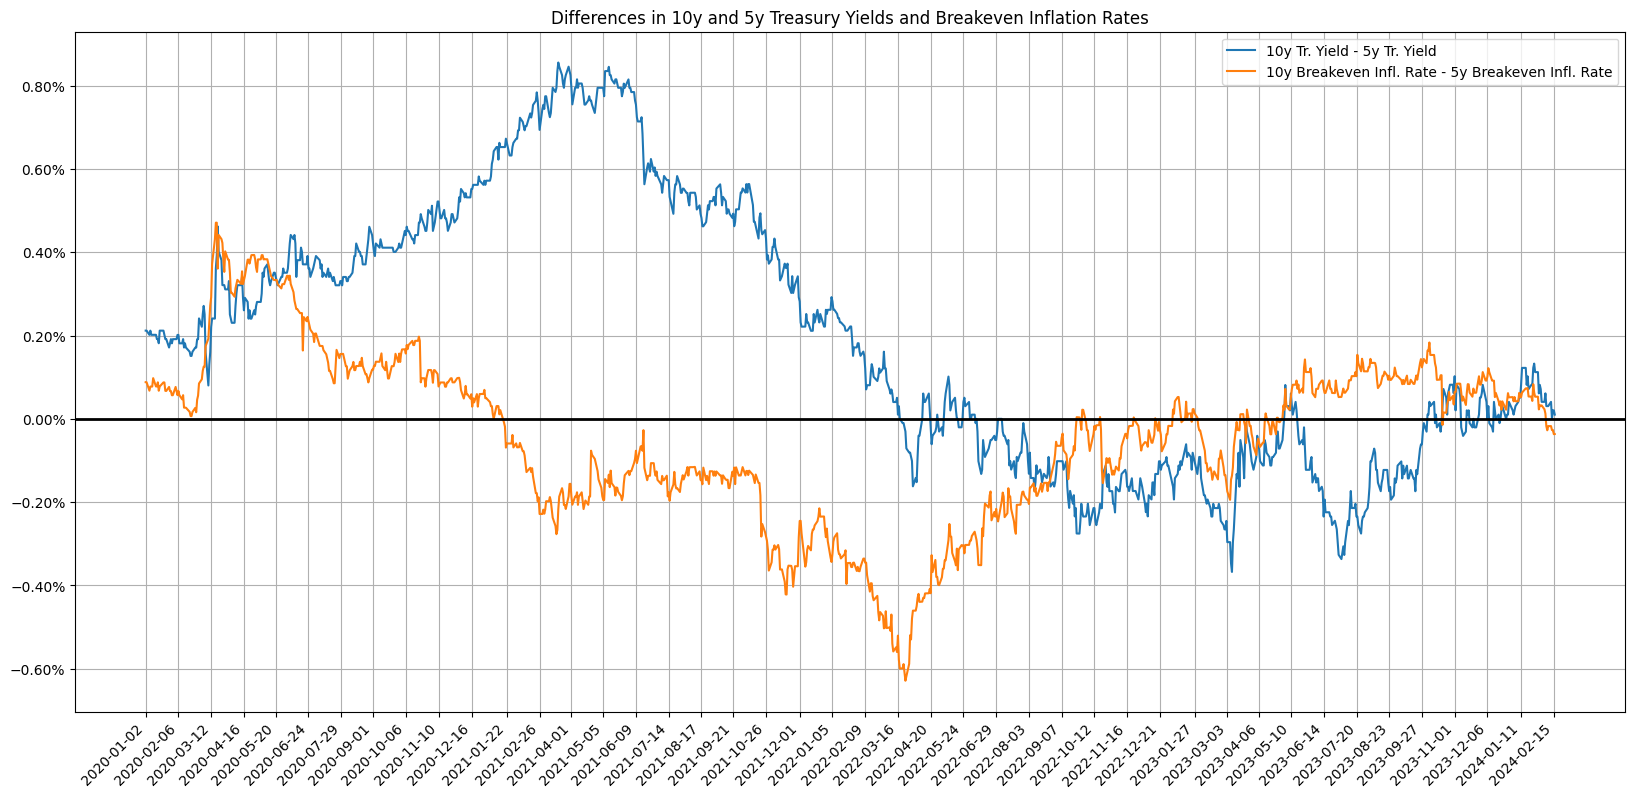

In [10]:
ax = data.iloc[:,:2].plot(figsize=(20,10), grid=True,
               title='Differences in 10y and 5y Treasury Yields and Breakeven Inflation Rates',
               xticks=data.index[::24], xlabel='', rot=45)
ax.axhline(y=0, lw=2, c='k')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

### Principal Component Analysis

In [11]:
%matplotlib inline
import os
import io
import time
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
from pandas_datareader.fred import FredReader
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# download treasury curves from Fred
codes = ['DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30']
end_date = datetime.today()
start_date = datetime(2000, 1, 1)
df = pd.DataFrame()

for code in codes:
    reader = FredReader(code, start_date, end_date)
    df0 = reader.read()
    df = df.merge(df0, how='outer', left_index=True, right_index=True, sort=False)
    reader.close()
df.dropna(axis = 0, inplace = True)
df = df['2020':]

In [13]:
df.head()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2020-01-02,1.53,1.54,1.57,1.56,1.58,1.59,1.67,1.79,1.88,2.19,2.33
2020-01-03,1.52,1.52,1.55,1.55,1.53,1.54,1.59,1.71,1.80,2.11,2.26
2020-01-06,1.54,1.56,1.56,1.54,1.54,1.56,1.61,1.72,1.81,2.13,2.28
2020-01-07,1.52,1.54,1.56,1.53,1.54,1.55,1.62,1.74,1.83,2.16,2.31
2020-01-08,1.50,1.54,1.56,1.55,1.58,1.61,1.67,1.78,1.87,2.21,2.35


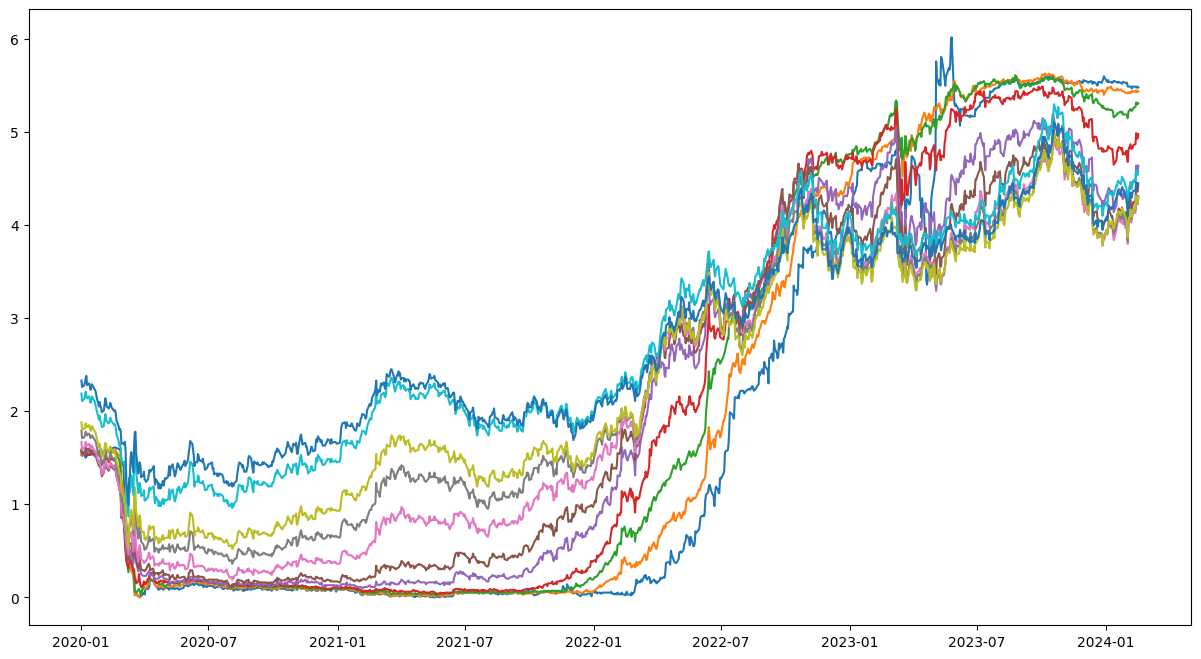

In [14]:
# view the yield curve
plt.figure(figsize=(15,8))
plt.plot(df)
plt.show()

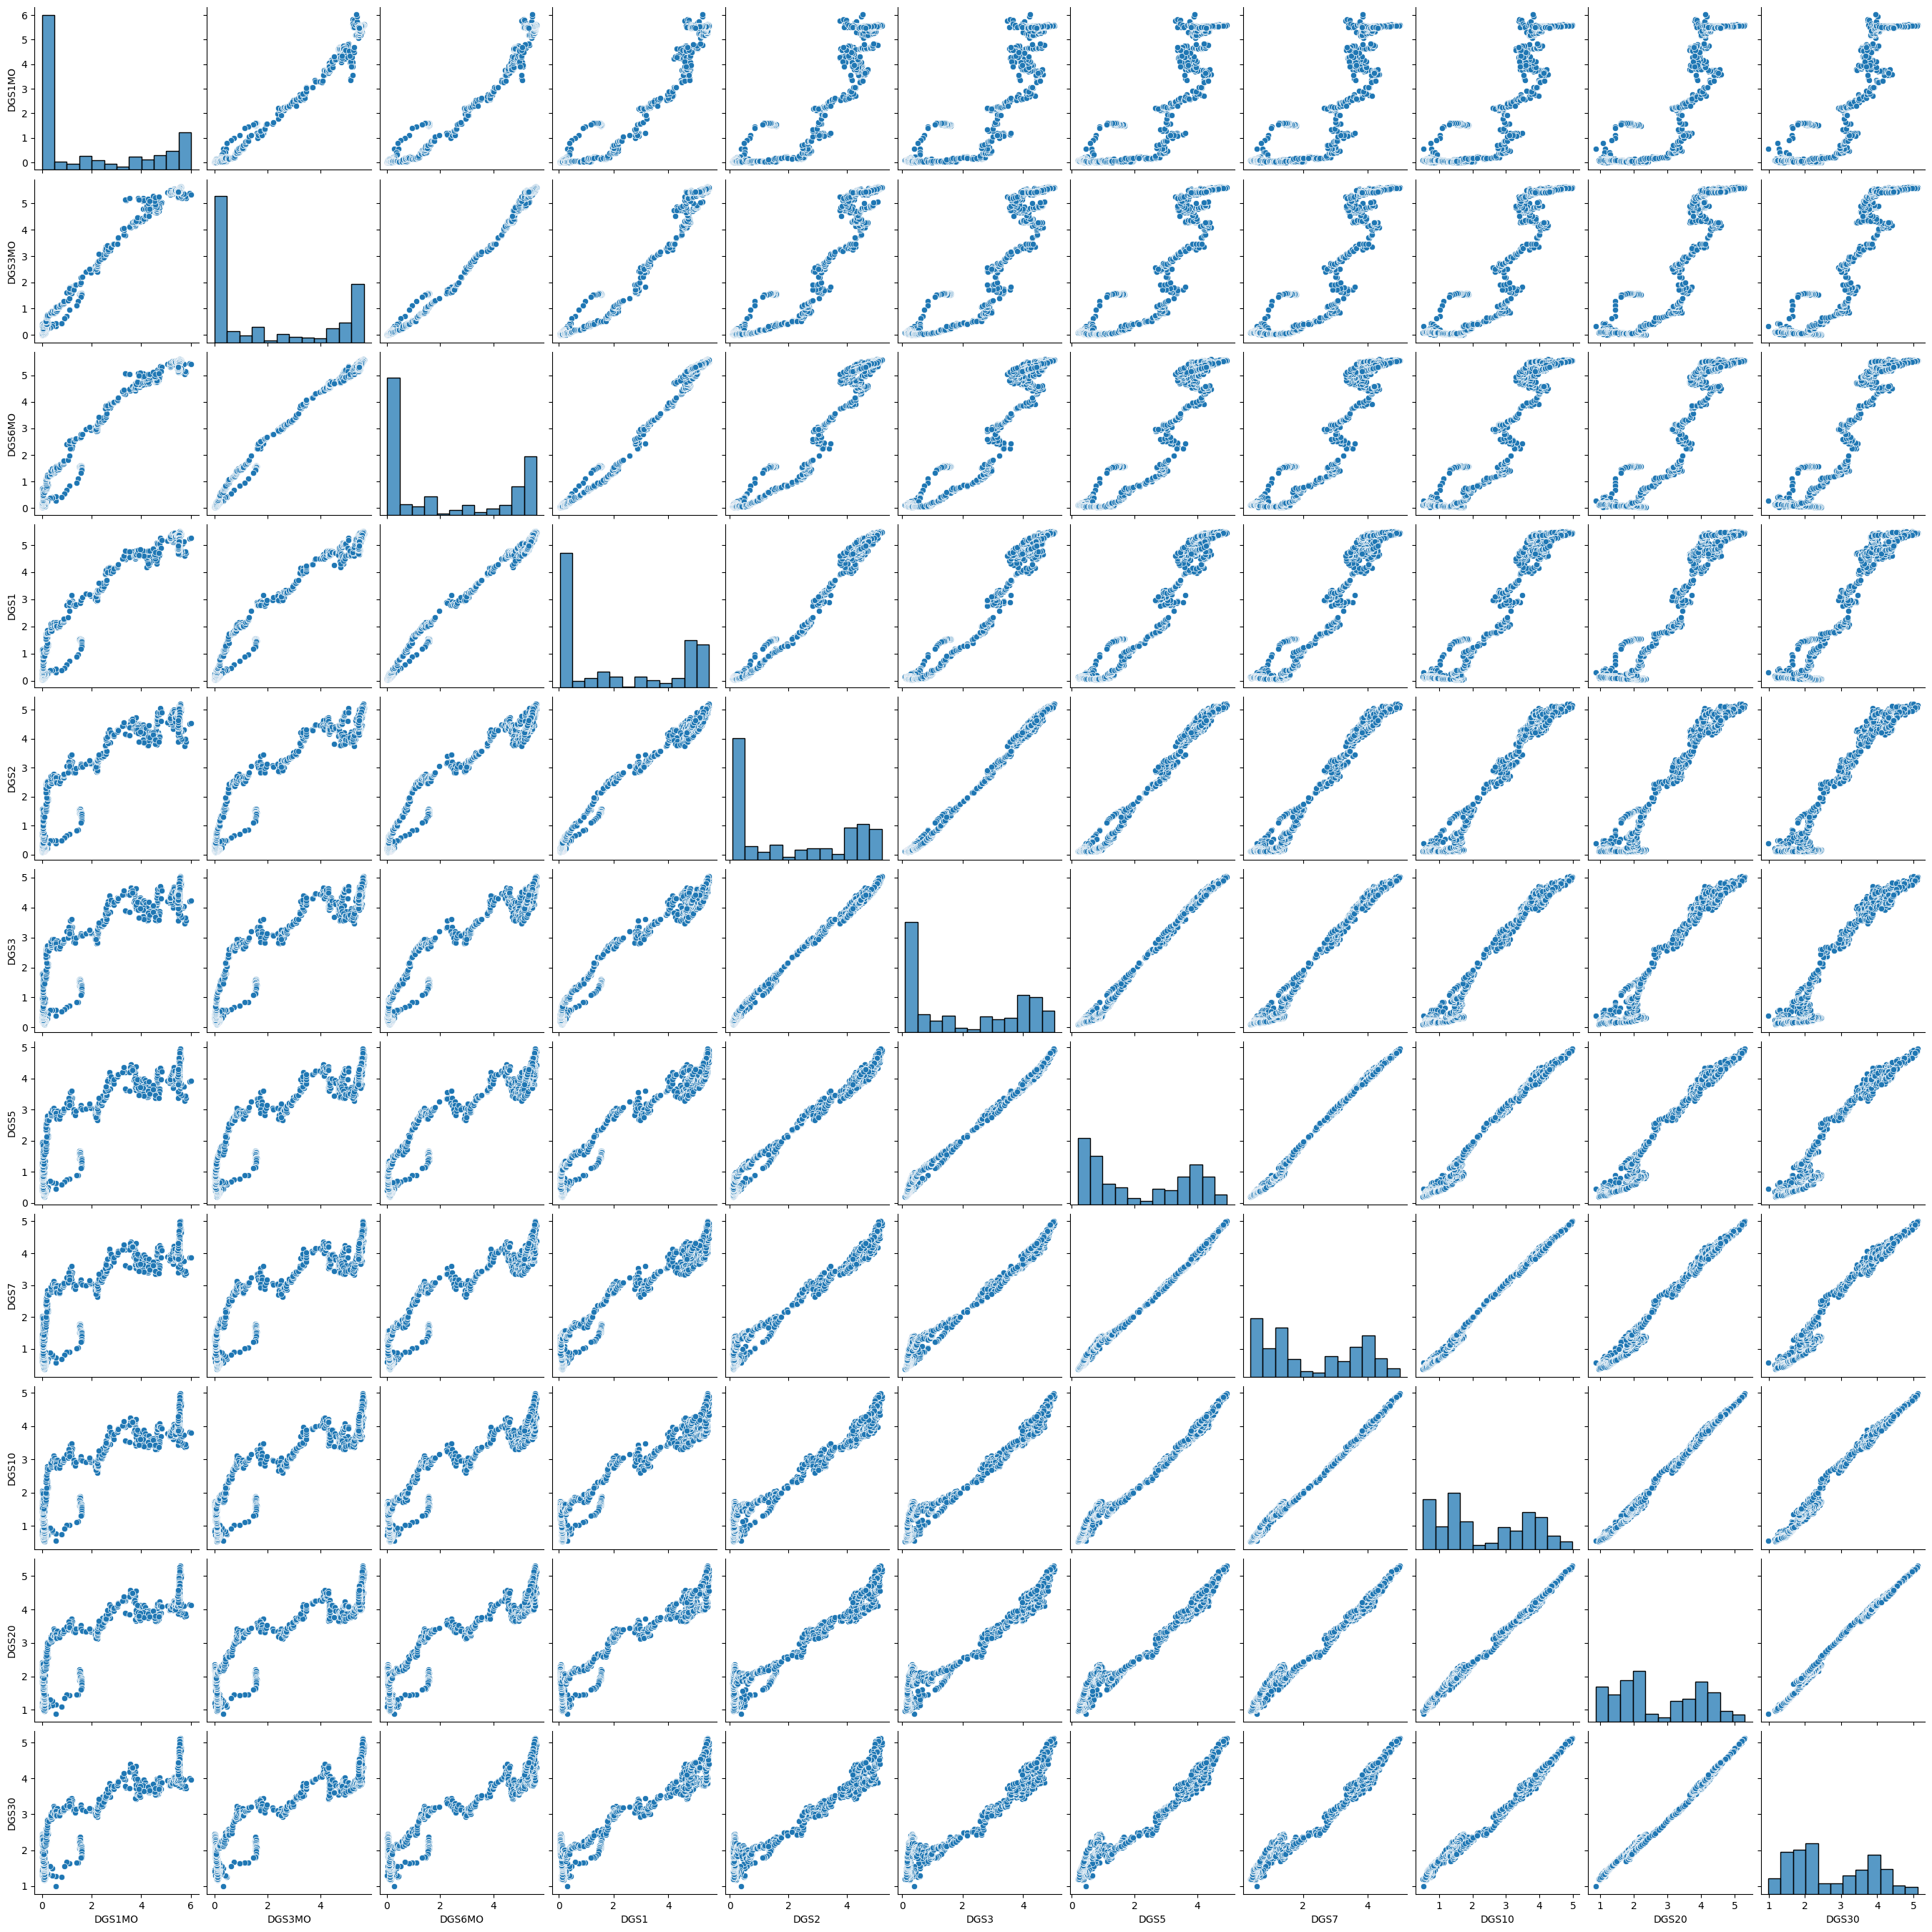

In [6]:
# correlation among tenors
sns.pairplot(df)

In [7]:
# covariance
df.cov()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,5.029526,5.091947,5.023107,4.724314,4.079609,3.675575,3.191188,2.919739,2.677265,2.492656,2.229392
DGS3MO,5.091947,5.215886,5.179376,4.899293,4.257720,3.849762,3.342097,3.051342,2.789939,2.595206,2.309895
DGS6MO,5.023107,5.179376,5.185083,4.939426,4.328642,3.929797,3.412970,3.110072,2.834984,2.634061,2.331586
DGS1,4.724314,4.899293,4.939426,4.744403,4.198438,3.828663,3.329996,3.030477,2.755423,2.556168,2.251511
DGS2,4.079609,4.257720,4.328642,4.198438,3.769007,3.461256,3.021854,2.748291,2.492211,2.307441,2.019293
DGS3,3.675575,3.849762,3.929797,3.828663,3.461256,3.193064,2.797775,2.546606,2.308398,2.137393,1.864110
DGS5,3.191188,3.342097,3.412970,3.329996,3.021854,2.797775,2.468237,2.256334,2.051926,1.904938,1.660063
DGS7,2.919739,3.051342,3.110072,3.030477,2.748291,2.546606,2.256334,2.070790,1.890084,1.759753,1.535940
DGS10,2.677265,2.789939,2.834984,2.755423,2.492211,2.308398,2.051926,1.890084,1.732276,1.618022,1.416117
DGS20,2.492656,2.595206,2.634061,2.556168,2.307441,2.137393,1.904938,1.759753,1.618022,1.518028,1.330160


In [8]:
# correlation
df.corr()

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DGS1MO,1.000000,0.994160,0.983628,0.967129,0.937004,0.917187,0.905723,0.904717,0.907025,0.902109,0.918340
DGS3MO,0.994160,1.000000,0.995946,0.984869,0.960284,0.943335,0.931454,0.928451,0.928158,0.922291,0.934349
DGS6MO,0.983628,0.995946,1.000000,0.995882,0.979175,0.965803,0.954028,0.949127,0.945941,0.938876,0.945920
DGS1,0.967129,0.984869,0.995882,1.000000,0.992850,0.983677,0.973105,0.966835,0.961145,0.952486,0.954914
DGS2,0.937004,0.960284,0.979175,0.992850,1.000000,0.997738,0.990756,0.983742,0.975355,0.964667,0.960875
DGS3,0.917187,0.943335,0.965803,0.983677,0.997738,1.000000,0.996588,0.990353,0.981518,0.970824,0.963715
DGS5,0.905723,0.931454,0.954028,0.973105,0.990756,0.996588,1.000000,0.998026,0.992338,0.984119,0.976140
DGS7,0.904717,0.928451,0.949127,0.966835,0.983742,0.990353,0.998026,1.000000,0.997941,0.992531,0.986023
DGS10,0.907025,0.928158,0.945941,0.961145,0.975355,0.981518,0.992338,0.997941,1.000000,0.997783,0.993966
DGS20,0.902109,0.922291,0.938876,0.952486,0.964667,0.970824,0.984119,0.992531,0.997783,1.000000,0.997343


In [9]:
# perform PCA
from sklearn.decomposition import PCA
pca = PCA().fit(df)        # call fit or fit_transform

In [10]:
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))

[9.68543694e-01 2.50337040e-02 5.26625017e-03 7.84764798e-04
 2.14352347e-04 7.74445846e-05 3.88742463e-05 2.01374621e-05
 1.35820268e-05 4.66352053e-06 2.53270688e-06]
[0.96854369 0.9935774  0.99884365 0.99962841 0.99984277 0.99992021
 0.99995908 0.99997922 0.9999928  0.99999747 1.        ]


Text(0, 0.5, 'cumulative explained variance')

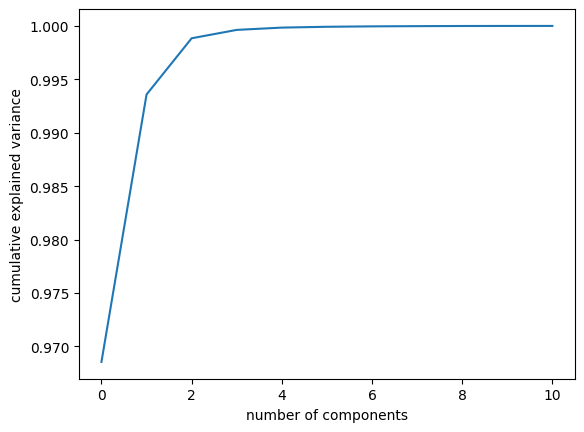

In [11]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

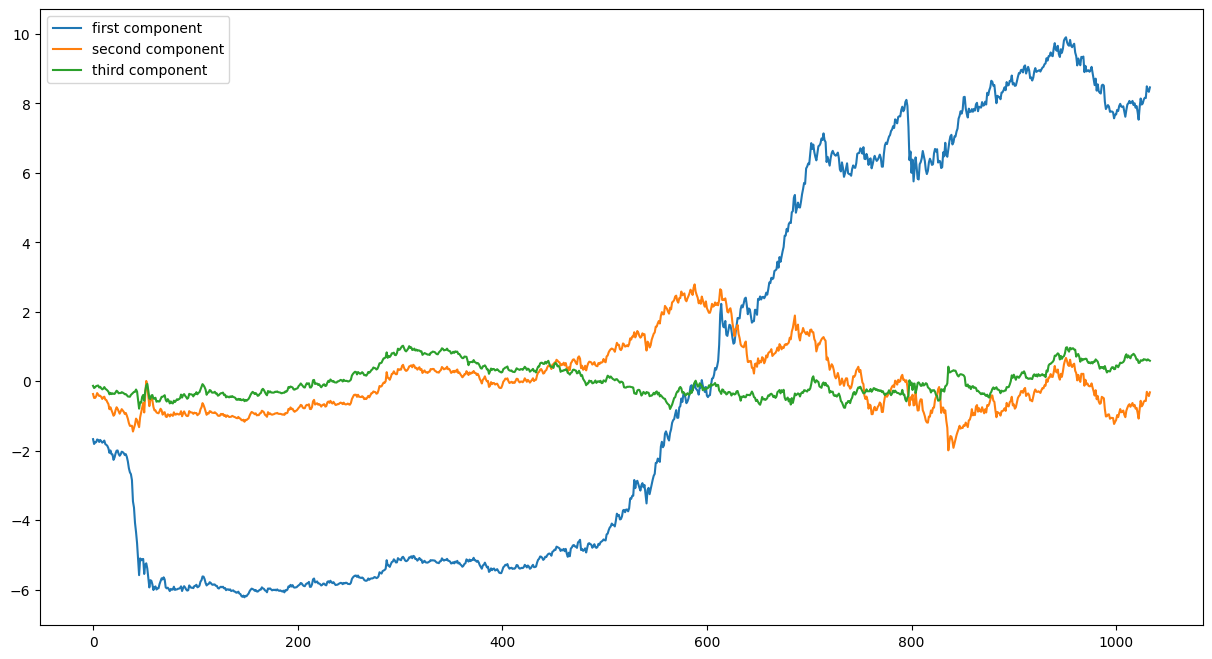

In [12]:
df_pca = pca.transform(df)            # eigenvector
plt.figure(figsize=(15,8))
plt.plot(df_pca[:, 0], label='first component')
plt.plot(df_pca[:, 1], label='second component')
plt.plot(df_pca[:, 2], label='third component')
plt.legend()
plt.show()

In [14]:
# optional: more information
print(pca.singular_values_.shape)        # SVD
print(pca.get_covariance().shape)       # covariance
print(pca.components_.shape)         # l*p, W^T

(11,)
(11, 11)
(11, 11)


In [1]:
# optional: call fit_transform directly
df_pca_123 = PCA(n_components=3).fit_transform(df)     
df_pca_123 = pd.DataFrame(data = df_pca_123, columns = ['first component', 'second component', 'third component'])
print(df_pca_123.shape)

NameError: name 'PCA' is not defined